In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import copy

import seaborn as sns
from matplotlib import pyplot as plt

import torch
cuda = torch.cuda.is_available()
print("GPU:", cuda)

from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

from collections import OrderedDict
from scipy import stats
from scipy.stats import gaussian_kde

from copy import deepcopy

GPU: False
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
train = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/datasets/fashion-mnist_train.csv")

label_dict = {0:'top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle'}

class_num = len(label_dict)

train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
X = train.iloc[:,1:].values / 255
Y = train.iloc[:,0].values

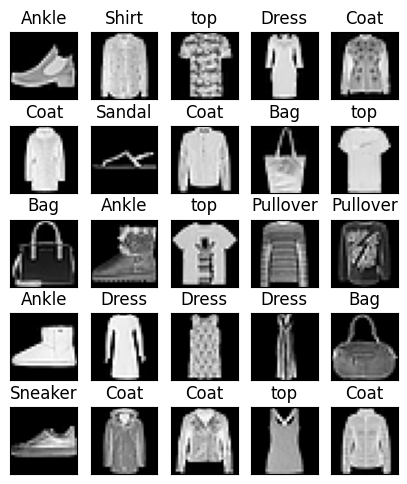

In [94]:
r = 5
c = 5
fig=plt.figure(figsize=(r, c*1.2), dpi=100)
for i in range(1, r*c+1):
    img = X[i].reshape(28,28)
    ax = fig.add_subplot(r, c, i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(label_dict[Y[i]])
    
    plt.imshow(img,cmap='gray')
plt.show()

In [95]:
from sklearn.model_selection import train_test_split

trn_x,val_x,trn_y,val_y = train_test_split(X,Y,test_size=0.2)

In [96]:
#converting our data into a datloader object.

trn_x = torch.from_numpy(trn_x).type(torch.FloatTensor)
trn_y = torch.from_numpy(trn_y).type(torch.LongTensor)

val_x = torch.from_numpy(val_x).type(torch.FloatTensor)
val_y = torch.from_numpy(val_y).type(torch.LongTensor)

In [97]:
from torch.utils.data import TensorDataset,DataLoader

trn = TensorDataset(trn_x,trn_y)
val = TensorDataset(val_x,val_y)

trn = DataLoader(trn,batch_size=1000)
val = DataLoader(val,batch_size=1000)

In [98]:
shape = trn_x[0].shape
shape

torch.Size([784])

In [99]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(784,256)
        self.linear2 = nn.Linear(256,100)
        self.linear3 = nn.Linear(100,64)
        self.linear4 = nn.Linear(64,10)
    
    def forward(self,X):
        X1 = F.relu(self.linear1(X))
        X2 = F.relu(self.linear2(X1))
        X3 = F.relu(self.linear3(X2))
        X4 = self.linear4(X3)
        return X1, X2, X3, F.log_softmax(X4, dim=1)

mlp = Model()

if cuda:
    mlp.cuda()
    
print(mlp)    

Model(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=10, bias=True)
)


In [100]:
#define our optimizer
from torch.optim import Adam

optimizer = Adam(mlp.parameters(), lr=1e-3)

In [101]:
def compute_val_loss(val_x,val_y,model):
    if cuda:
        val_x,val_y = val_x.cuda(),val_y.cuda()
    output = model(val_x)[3]
    loss = F.cross_entropy(output,val_y)
    return loss

In [102]:
%%time
EPOCHS = 10

trn_loss = []
val_loss = []

mlp.train()

for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(trn):

        if cuda:
            data,target = data.cuda(),target.cuda()
            
        optimizer.zero_grad()
        
        _, _, _, y_pred = mlp(data)

        loss = F.cross_entropy(y_pred, target)
        trn_loss.append(loss.cpu().data.item())
        
        loss.backward()
        optimizer.step()
        
        loss = compute_val_loss(val_x,val_y,mlp)
        val_loss.append(loss.cpu().data.item())

    print("Epoch: {} | loss: {} | val_loss: {}".format(epoch+1,trn_loss[-1],val_loss[-1]))

Epoch: 1 | loss: 0.7049036622047424 | val_loss: 0.6686334013938904
Epoch: 2 | loss: 0.535564124584198 | val_loss: 0.5120334625244141
Epoch: 3 | loss: 0.475557804107666 | val_loss: 0.4607572555541992
Epoch: 4 | loss: 0.44006645679473877 | val_loss: 0.426484614610672
Epoch: 5 | loss: 0.4153102934360504 | val_loss: 0.40298593044281006
Epoch: 6 | loss: 0.3978760540485382 | val_loss: 0.3886586129665375
Epoch: 7 | loss: 0.38283807039260864 | val_loss: 0.3764230012893677
Epoch: 8 | loss: 0.3710065186023712 | val_loss: 0.3690956234931946
Epoch: 9 | loss: 0.35925066471099854 | val_loss: 0.3680860102176666
Epoch: 10 | loss: 0.347028523683548 | val_loss: 0.3674446642398834
CPU times: user 1min 19s, sys: 127 ms, total: 1min 19s
Wall time: 1min 23s


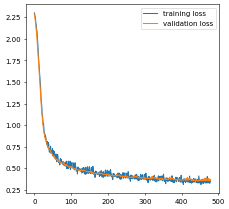

In [103]:
plt.figure(figsize=(5,5),dpi=50)
plt.plot(trn_loss,label='training loss')
plt.plot(val_loss,label='validation loss')
plt.legend(loc='upper right')

In [104]:
def predict(model,val_x,ret_fm=False):
    """
    ret_fm: when set True, return feature map of layers
    """
    if cuda: val_x = val_x.cuda()
    out = model(val_x)
   
    ret = []
    y_preds = []
    if(ret_fm == False):
        _, preds = torch.max(out[3].data,1)
        for p in preds: y_preds.append(p.detach().cpu().numpy().item())
        
        ret = y_preds
    else:
        f1 = out[0].data.detach().cpu().numpy().reshape(val_x.shape[0], -1)   # 12000 * 256
        f2 = out[1].data.detach().cpu().numpy().reshape(val_x.shape[0], -1)   # 12000 * 100
        f3 = out[2].data.detach().cpu().numpy().reshape(val_x.shape[0], -1)   # 12000 * 64

        _, preds = torch.max(out[3].data,1)
        for p in preds: y_preds.append(p.detach().cpu().numpy().item())
            
        ret = (f1, f2, f3, y_preds)
    
    return ret

In [105]:
pred = predict(mlp,val_x)

Accuracy: 86.84166666666667 %


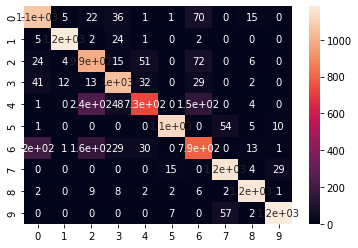

In [106]:
cm = confusion_matrix(val_y.numpy(), pred)

plt.figure()
sns.heatmap(cm,annot=True)

print("Accuracy:",accuracy_score(val_y.numpy(),pred)*100,"%")

tensor(1)


Text(0.5, 1.0, 'fm of layer2')

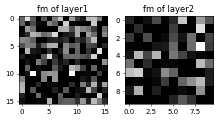

In [107]:
sp1 = val_x[0, :].reshape(1,-1)   # take one sample from validation set [1, 784]

res1 = predict(mlp,sp1,ret_fm=True)   # then make a prediction

print(val_y[0])  # true lable of the sample

plt.figure(figsize=(5, 3), dpi=50)
plt.subplot(121)
plt.imshow(res1[0].reshape(16, 16), cmap='gray')
plt.title("fm of layer1")
plt.subplot(122)
plt.imshow(res1[1].reshape(10, 10), cmap='gray')
plt.title("fm of layer2")

In [179]:
# begin testing
pred = predict(mlp, val_x, ret_fm=True)    # return (f1, f2, f3, y_preds)
pred[0].shape, pred[1].shape, pred[2].shape
pred_all = deepcopy(pred)

Each layer generates either of the two feature maps: 

1. **positive** feature map(on the correctly classified sample)
2. **negative** feature map(on the mis-classified sample)

i.e. for any class $c$ we have:
$$\bar x_{pos,c} = \frac{1}{M}\sum^{m}_{M}\sum_{k=0}^{K}x_{pos,c}^{(m)}$$
and
$$\bar x_{neg,c} = \frac{1}{M}\sum^{m}_{M}\sum_{k=0}^{K}x_{neg,c}^{(m)}$$

In [165]:
layer_num = len(pred) - 1

In [166]:
def get_benchmarks(val_y, pred, method=1):
    target = val_y.numpy()
    y_pred = pred[-1]

    if method == 1:

        benchmarks = dict()
        for l in range(layer_num):      # for all layers
            benchmarks[l] = {'pos':None, 'neg':None}     # feature map dict {layer0: {pos_dict, neg_dict}, layer1:{},,,}
            
            current_layer_fm = pred[l]                    # size: 12000*256
            pos_dict = dict()               # {'0': (numpy(1*256), t)}  t is the times '0' is visited
            neg_dict = dict()
            for i in range(current_layer_fm.shape[0]):    # for all samples
                if(y_pred[i] == target[i]):
                    if target[i] not in pos_dict:   # if the first time
                        pos_dict[target[i]] = (current_layer_fm[i], 1)
                    else:
                        t = pos_dict[target[i]][1]
                        pos_dict[target[i]] = (pos_dict[target[i]][0] * t + current_layer_fm[i]) / (t + 1)
                        pos_dict[target[i]][1] += 1
                else:
                    if target[i] not in neg_dict:
                        neg_dict[target[i]] = (current_layer_fm[i], 1)
                    else:
                        t = neg_dict[target[i]][1]
                        neg_dict[target[i]] = (neg_dict[target[i]][0] * t + current_layer_fm[i]) / (t + 1)
                        neg_dict[target[i]][1] += 1
            
            benchmarks[l]['pos'] = pos_dict
            benchmarks[l]['neg'] = neg_dict
        
        return benchmarks
    
    elif method == 2:

        # init dict
        d = dict()
        for l in range(layer_num):
            d[l] = {'pos': dict(), 'neg': dict()}
            for c in range(class_num):
                d[l]['pos'][c] = []
                d[l]['neg'][c] = []
        benchmarks = d.copy()

        # collecting
        for l in range(layer_num):
            current_layer_fm = pred[l]  # size: 12000*256
            for i in range(current_layer_fm.shape[0]):
                s = 'pos' if y_pred[i] == target[i] else 'neg'
                d[l][s][target[i]].append(current_layer_fm[i])
        
        # skip outliers
        for l in range(layer_num):
            for s in ['pos', 'neg']:
                for c in range(class_num):
                    fms = np.array(d[l][s][c])
                    benchmark = np.zeros((fms[0].shape))
                    
                    Z = 3
                    z = np.abs(stats.zscore(fms, axis=1))
                    z[np.where(z > Z)] = 0
                    for j in range(fms.shape[1]):
                        if np.count_nonzero(fms[:, j]) != 0:
                            benchmark[j] = np.sum(fms[:, j]) / np.count_nonzero(fms[:, j])  # calculate mean without outliers
                        else:
                            benchmark[j] = 0
                    benchmarks[l][s][c] = benchmark

        return benchmarks

In [167]:
"""
The function bhatta_dist() calculates the Bhattacharyya distance between two classes on a single feature.
    The distance is positively correlated to the class separation of this feature. Four different methods are
    provided for calculating the Bhattacharyya coefficient.

Created on 4/14/2018
Author: Eric Williamson (ericpaulwill@gmail.com)
https://github.com/EricPWilliamson/bhattacharyya-distance/blob/master/bhatta_dist.py
"""
def bhatta_dist(X1, X2):

    def get_density(x, cov_factor=0.1):
        density = gaussian_kde(x)
        density.covariance_factor = lambda:cov_factor
        density._compute_covariance()
        return density
    
    n_steps = X1.shape[1] * 2

    d1 = get_density(X1)
    d2 = get_density(X2)

    cX = np.concatenate((X1,X2))
    xs = np.linspace(np.min(cX),np.max(cX),n_steps)
    bht = 0

    for x in xs:
        p1 = d1(x)
        p2 = d2(x)
        bht += np.sqrt(p1*p2)*(np.max(cX)-np.min(cX))/n_steps
    
    return -np.log(bht) if bht != 0 else float('Inf')

In [168]:
def distance(benchmark, feature_map, method='L2', norm=True):
    """
    calculate the similarity between benchmark and a feature map
    """

    benchmark = benchmark.reshape(-1, 1)
    feature_map = feature_map.reshape(-1, 1)

    if norm is True:
        scaler = StandardScaler()
        benchmark = scaler.fit_transform(benchmark)
        feature_map = scaler.fit_transform(feature_map)

    if method == 'L2':
        return np.linalg.norm(benchmark - feature_map)
    if method == 'bha':
        return bhatta_dist(benchmark.reshape(1, -1), feature_map.reshape(1, -1))
    
    raise Exception("No designated method found.")

In [169]:
DISTANCE_METHOD = 'L2'
BENCHMARKS_METHOD = 2

In [154]:
benchmarks = get_benchmarks(val_y, pred, BENCHMARKS_METHOD)

class 0, layer 0, sim: 0.214462
class 0, layer 1, sim: 0.357175
class 0, layer 2, sim: 0.366900
class 1, layer 0, sim: 0.129796
class 1, layer 1, sim: 0.233039
class 1, layer 2, sim: 0.238353
class 2, layer 0, sim: 0.314819
class 2, layer 1, sim: 0.626289
class 2, layer 2, sim: 0.691928
class 3, layer 0, sim: 0.220079
class 3, layer 1, sim: 0.308948
class 3, layer 2, sim: 0.316146
class 4, layer 0, sim: 0.599824
class 4, layer 1, sim: 1.044638
class 4, layer 2, sim: 1.074275
class 5, layer 0, sim: 0.161019
class 5, layer 1, sim: 0.284401
class 5, layer 2, sim: 0.311213
class 6, layer 0, sim: 0.283763
class 6, layer 1, sim: 0.487892
class 6, layer 2, sim: 0.469596
class 7, layer 0, sim: 0.152056


<ipython-input-173-4b81a4042592>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(3, 1), dpi=50)


class 7, layer 1, sim: 0.319209
class 7, layer 2, sim: 0.392396
class 8, layer 0, sim: 0.128201
class 8, layer 1, sim: 0.239777
class 8, layer 2, sim: 0.228990
class 9, layer 0, sim: 0.191995
class 9, layer 1, sim: 0.461324
class 9, layer 2, sim: 0.574064


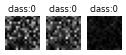

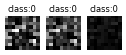

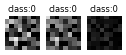

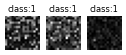

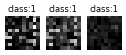

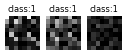

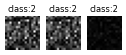

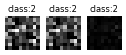

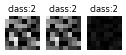

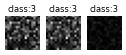

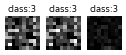

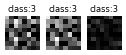

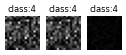

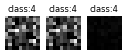

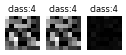

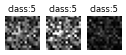

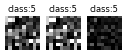

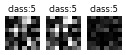

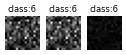

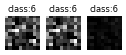

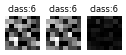

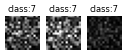

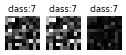

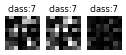

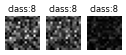

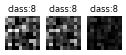

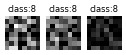

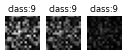

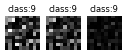

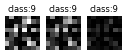

In [173]:
for c in range(class_num):
    for l in range(layer_num):
        fig = plt.figure(figsize=(3, 1), dpi=50)

        pos_bm = benchmarks[l]['pos'][c]
        neg_bm = benchmarks[l]['neg'][c]

        pos_bm = pos_bm.reshape(int(np.sqrt(len(pos_bm))), -1)
        neg_bm = neg_bm.reshape(int(np.sqrt(len(neg_bm))), -1)
        diff_bm = np.abs(np.subtract(pos_bm, neg_bm))

        imgs = [pos_bm, neg_bm, diff_bm]

        sim = 1 / distance(pos_bm, neg_bm, DISTANCE_METHOD)

        for i, img in enumerate(imgs):
            plt.subplot(1,3,i+1)
            plt.axis('off')
            plt.title('class:' + str(c))
            plt.imshow(img, cmap='gray')
            plt.clim(np.min(pos_bm), np.max(pos_bm))
        
        print('class %d, layer %d, sim: %f' % (c, l, sim))

In [174]:
np.array(pred[-1])

array([1, 7, 8, ..., 6, 7, 6])

In [175]:
val_y

tensor([1, 7, 8,  ..., 0, 7, 6])

- TODO: count similarities on all sample data, find a threshold

In [158]:
# init dict
dsb = dict()    # distribution dict
for l in range(layer_num):
    pos_dict = dict()
    neg_dict = dict()
    for c in range(class_num):
        pos_dict[c] = []
        neg_dict[c] = []
    dsb[l] = {'pos': pos_dict, 'neg': neg_dict}

for i in tqdm(range(val_x.shape[0])):
    pred = predict(mlp, val_x[i, :].reshape(1,-1), ret_fm=True)
    y_pred = pred[-1][0]
    target = int(val_y[i].numpy())

    for l in range(layer_num):  # compare on each layer
        bench_fm = benchmarks[l]['pos'][target]    # there're two benchmarks, only take positive one since it's meaningful
        fm = pred[l]

        sim = 1 / distance(bench_fm, fm, method=DISTANCE_METHOD)

        if y_pred == target:
            dsb[l]['pos'][target].append(sim)
        else:
            dsb[l]['neg'][target].append(sim)

100%|██████████| 12000/12000 [00:56<00:00, 210.54it/s]


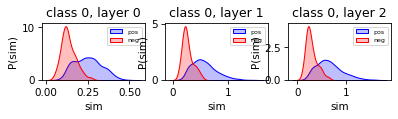

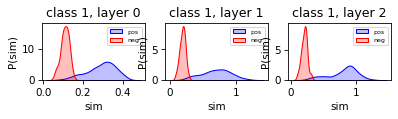

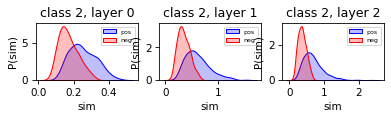

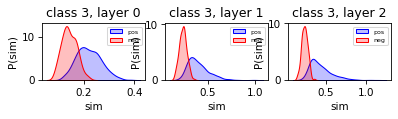

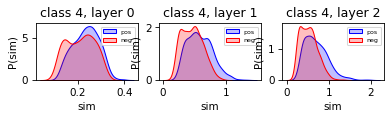

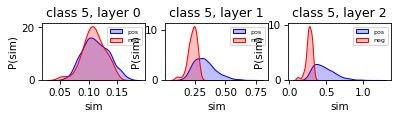

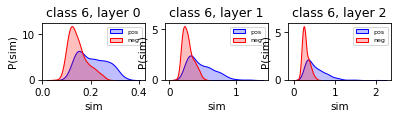

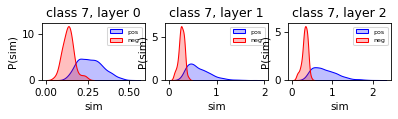

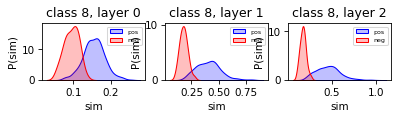

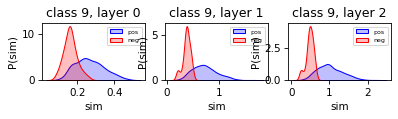

In [159]:
for c in range(class_num):
    fig = plt.figure(figsize=(6, 1), dpi=75)
    for l in range(layer_num):
        
        pos_data = dsb[l]['pos'][c]
        neg_data = dsb[l]['neg'][c]
        
        plt.subplot(1, layer_num, l+1)
        ax = sns.kdeplot(pos_data, color="Blue", fill = True)
        ax = sns.kdeplot(neg_data, ax=ax, color="Red", fill= True)
        ax.legend(["pos","neg"],loc='upper right',prop={'size': 6})
        ax.set_ylabel('P(sim)')
        ax.set_xlabel('sim')
        ax.set_title('class %d, layer %d' % (c, l))

&emsp;&emsp; We can see from the kernel density distribution plots above that for most classes negative samples(red) are subjected to a different distribution from that of the positive samples. They tend to have a lower density.

&emsp;&emsp; Beware, if we change similarity metrics or normalization, the results might be different.

In [180]:
correct_list = [0] * class_num
counter_list = [0] * class_num
for i in range(len(val_y)):
    counter_list[val_y[i]] += 1
    if(int(val_y[i]) == pred_all[-1][i]):
        correct_list[val_y[i]] += 1

for i in range(class_num):
    print('class %d acc: %f' % (i, correct_list[i] / counter_list[i]))

class 0 acc: 0.876340
class 1 acc: 0.972039
class 2 acc: 0.852107
class 3 acc: 0.890213
class 4 acc: 0.619454
class 5 acc: 0.941374
class 6 acc: 0.645611
class 7 acc: 0.960100
class 8 acc: 0.973266
class 9 acc: 0.947115


Note: Take out those neg samples with large sim -> how are they classified to pos sample?

Note: take 1 neg with very large sim and 1 pos

4 kinds of images: pos+sim, pos-sim, neg+sim, neg-sim

find 5 pics for each

In [181]:
obs_l = 0   # layer in observance
obs_c = 6   # class in observance

Q1_pos = np.quantile(dsb[obs_l]['pos'][obs_c], 0.25)
Q3_pos = np.quantile(dsb[obs_l]['pos'][obs_c], 0.75)
Q1_neg = np.quantile(dsb[obs_l]['neg'][obs_c], 0.25)
Q3_neg = np.quantile(dsb[obs_l]['neg'][obs_c], 0.75)

imobs_dict = {'pos_Q1': [], 'pos_Q3': [], 'neg_Q1': [], 'neg_Q3': []}
for i in range(val_x.shape[0]):
    if(int(val_y[i]) == obs_c):     # only class in observance will be picked up       
        pred = predict(mlp, val_x[i, :].reshape(1,-1), ret_fm=True)

        y_pred = pred[-1][0]
        target = obs_c

        fm = pred[obs_l]
        benchmark = benchmarks[obs_l]['pos'][obs_c]
        sim = 1 / distance(benchmark, fm)

        if(y_pred == target):   # pos
            if(sim < Q1_pos and len(imobs_dict['pos_Q1']) < 5):
                imobs_dict['pos_Q1'].append(i)  # put index
            elif(sim > Q3_pos and len(imobs_dict['pos_Q3']) < 5):
                imobs_dict['pos_Q3'].append(i)
        else:
            if(sim < Q1_neg and len(imobs_dict['neg_Q1']) < 5):
                imobs_dict['neg_Q1'].append(i)  # put index
            elif(sim > Q3_neg and len(imobs_dict['neg_Q3']) < 5):
                imobs_dict['neg_Q3'].append(i)
        
        # found 5 imgs for 4 types, exit
        if(len(imobs_dict['pos_Q1']) == 5 and len(imobs_dict['pos_Q3']) == 5 and 
           len(imobs_dict['neg_Q1']) == 5 and len(imobs_dict['neg_Q3']) == 5):
           break

if(len(imobs_dict['pos_Q1']) != 5 or len(imobs_dict['pos_Q3']) != 5 or 
   len(imobs_dict['neg_Q1']) != 5 or len(imobs_dict['neg_Q3']) != 5):
   raise  Exception("Fetch images failed.")

The first row are the images that are classified correctly but have a low similarity with the benchmark of the class.

The second row are the images classified correctly whose similarity is higher than 75% of total samples.

The third row images are misclassified and has a low similarity to benchmark.

The forth row images are misclassified but has a high similarity to benchmark.

The 2nd row looks really eriee... how are these clothes shirts??? They could look like anything(e.g. shirt, coat...) but shirts. NO wonders the network can not gain a high acc..

class 6: Shirt, layer 0


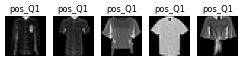

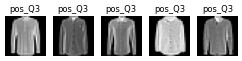

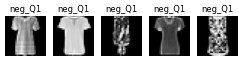

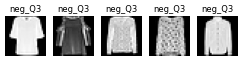

In [182]:
print('class %d: %s, layer %d' % (obs_c, label_dict[obs_c], obs_l))
for key in list(imobs_dict.keys()):
    fig = plt.figure(dpi=50)
    for i, index in enumerate(imobs_dict[key]):
        img = val_x[index].reshape(int(np.sqrt(len(val_x[index]))), -1)
        plt.subplot(1,5,i+1)
        plt.axis('off')
        plt.imshow(img, cmap='gray')
        plt.title(key)

In [183]:
def trace(x, target, benchmarks, prt=False):
    """
    x: a sample, input image
    target: true label of this sample
    """
    pred = predict(mlp, x, True)
    if(prt): print("pred label: " + str(pred[-1][0]))

    traces = []
    for l in range(len(pred) - 1):
        fm = pred[l]                    # feature map on current layer
        bms = [benchmarks[l]['pos'][i] for i in range(len(benchmarks[l]['pos']))]
        sims = [round(1 / distance(bm, fm, 'L2'), 6) for bm in bms]
        traces.append(np.argmax(sims))
        if(prt): print(sims)
    
    return traces

In [184]:
imobs_dict['pos_Q1'], imobs_dict['pos_Q3'], imobs_dict['neg_Q1'], imobs_dict['neg_Q3']

([61, 101, 127, 143, 181],
 [38, 88, 133, 219, 244],
 [281, 500, 881, 940, 1121],
 [89, 179, 213, 234, 274])

In [188]:
OBS_INDEX = 61

In [189]:
trace(val_x[OBS_INDEX, :].reshape(1,-1), 6, benchmarks, prt=True)

pred label: 6
[0.085106, 0.064796, 0.126194, 0.078919, 0.144776, 0.051525, 0.151455, 0.053211, 0.070717, 0.05161]
[0.167816, 0.104121, 0.220018, 0.127251, 0.240147, 0.081715, 0.32932, 0.077322, 0.122358, 0.079527]
[0.184125, 0.108264, 0.234706, 0.133143, 0.244955, 0.089148, 0.385258, 0.083057, 0.126721, 0.085984]


[6, 6, 6]

0.04341384638526939


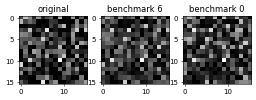

In [190]:
plt.figure(dpi=50)

plt.subplot(1,3,1)
plt.title('original')
plt.imshow(predict(mlp, val_x[OBS_INDEX, :].reshape(1,-1), True)[0].reshape(16, 16), cmap='gray')

plt.subplot(1,3,2)
plt.title('benchmark 6')
plt.imshow(benchmarks[0]['pos'][6].reshape(16, 16), cmap='gray')

plt.subplot(1,3,3)
plt.title('benchmark 0')
plt.imshow(benchmarks[0]['pos'][0].reshape(16, 16), cmap='gray')

print(1 / np.linalg.norm(benchmarks[0]['pos'][6] - predict(mlp, val_x[68, :].reshape(1,-1), True)[0]))

Note: improve similarity function and benchmark generation

TODO: Reliability Analysis. Counting the pos and neg trace

In [191]:
# init dict
trace_dict = dict()
for c in range(class_num):
    trace_dict[c] = {'pos': [], 'neg': []}

for i in tqdm(range(val_x.shape[0])): 
    val_x_tmp = val_x[i, :].reshape(1,-1)

    tc = trace(val_x_tmp, val_y[i], benchmarks) # get trace

    pred = predict(mlp, val_x_tmp, True)
    y_pred = pred[-1][0]
    target = int(val_y[i])
    
    if(y_pred == target):
        trace_dict[target]['pos'].append(tc)
    else:
        trace_dict[target]['neg'].append(tc)

100%|██████████| 12000/12000 [07:34<00:00, 26.41it/s]


class 0 layer 0, reliability: 0.904045
class 0 layer 1, reliability: 0.956726
class 0 layer 2, reliability: 0.961430
class 1 layer 0, reliability: 0.972081
class 1 layer 1, reliability: 0.985618
class 1 layer 2, reliability: 0.991540
class 2 layer 0, reliability: 0.837538
class 2 layer 1, reliability: 0.905146
class 2 layer 2, reliability: 0.889001
class 3 layer 0, reliability: 0.960803
class 3 layer 1, reliability: 0.953155
class 3 layer 2, reliability: 0.956979
class 4 layer 0, reliability: 0.833333
class 4 layer 1, reliability: 0.983471
class 4 layer 2, reliability: 0.982094
class 5 layer 0, reliability: 0.272242
class 5 layer 1, reliability: 0.899466
class 5 layer 2, reliability: 0.919929
class 6 layer 0, reliability: 0.588310
class 6 layer 1, reliability: 0.735705
class 6 layer 2, reliability: 0.756036
class 7 layer 0, reliability: 0.946320
class 7 layer 1, reliability: 0.940260
class 7 layer 2, reliability: 0.943723
class 8 layer 0, reliability: 0.958798
class 8 layer 1, reliabil

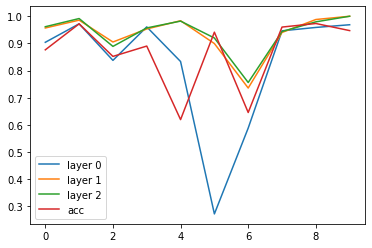

In [192]:
rlb_dict = dict()

acc_list = [correct_list[i] / counter_list[i] for i in range(class_num)]

for l in range(layer_num):
    rlb_dict[l] = []

for c in range(class_num):
    trace_pos = np.array(trace_dict[c]['pos'])
    trace_neg = np.array(trace_dict[c]['neg'])

    for l in range(layer_num):

        reliability = np.mean(np.array(trace_dict[c]['pos'])[:, l] == c)

        rlb_dict[l].append(reliability)  # haven't considered the weights from sample size yet

        print("class %d layer %d, reliability: %f" % (c, l, reliability))

plt.figure()
for l in range(layer_num):
    print("layer %d reliability: %f" % (l, np.sum(rlb_dict[l])))
    plt.plot(rlb_dict[l], label='layer '+str(l))
plt.plot(acc_list, label='acc')
plt.legend()

The reliability here indicates that, take class `0` for instance, `93.6979%` positive samples is predicted as '0' by the first layer. Likewise, `95.4588%` positive samples is predicted to be '0' on the second layer.

Note: Why the reliability of class 9 is so low but the acc is so high? Assumption: the similarity still needs improvement.

Layer 1 has the greatest reliability. So it's selected as the **Judge Layer**
- Question: can we take different layers so that at anytime the best reliability can be acchieved? 
- A: No, test sets are always unknown. But we can prefer a 'global' layer or 'problem-oriented' layer.

Before moving on, we can attempt to illustrate traces.

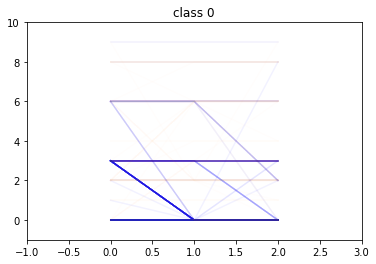

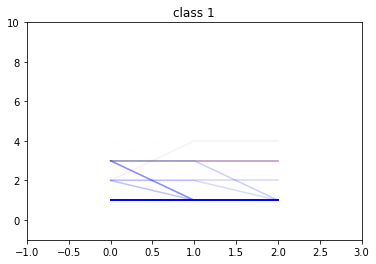

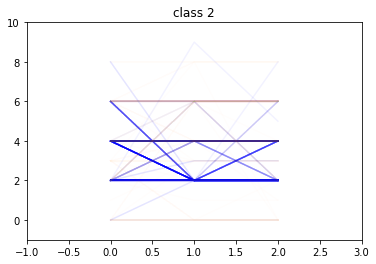

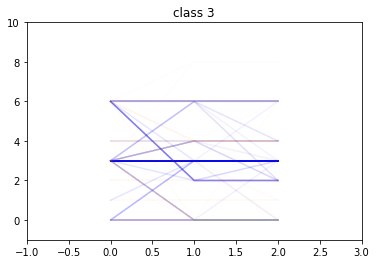

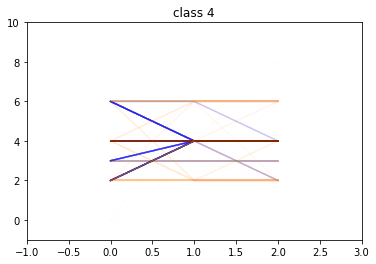

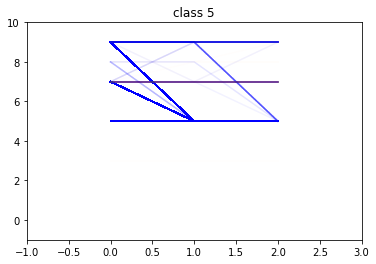

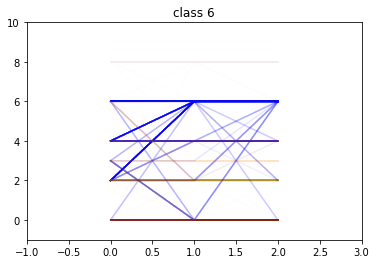

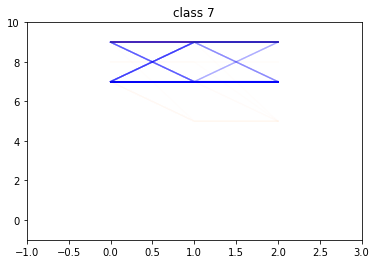

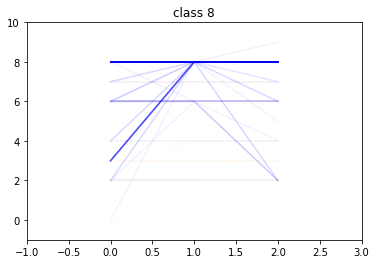

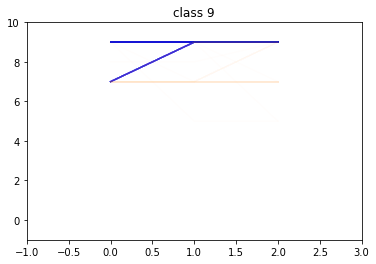

In [193]:
for c in range(class_num):
    fig = plt.figure()
    plt.title('class %d' % c)

    trace_pos = np.array(trace_dict[c]['pos'])
    trace_neg = np.array(trace_dict[c]['neg'])

    cl = ["blue", "orange"]
    alphas = [0.05, 0.01]
    for i, tcs in enumerate([trace_pos, trace_neg]):
        for tc in tcs:
            plt.plot(tc, color=cl[i], alpha=alphas[i])
            plt.xlim([-1, layer_num])
            plt.ylim([-1, class_num])

**What are we gonna do with the "Judge Layer"?**

One of the most intuitive methods is "What-I-Say-Goes".

But seperate judge layers is not accurate enough. We can combine multiple judge layers into the <mark>Jury</mark>

TODO: Count the top-k frequent traces for each class and represent them as decisive traces.

In [194]:
K = 5

In [232]:
def find_top_K_traces(traces, K):

    def list2str(ls):
        s = ""
        for item in ls: s += str(item) + '-'
        return s[:-1]

    # counting frequency
    size = [class_num] * layer_num
    cube = np.zeros(size)   # index is trace state
    for tc in traces:
        cube[tuple(tc)] += 1    

    c_d = dict()    # cube dict, key is frequency, value is index(state)
    for i in range(class_num):
        for j in range(class_num):
            for k in range(class_num):
                if(cube[i][j][k] != 0):
                    c_d[cube[i][j][k]] = list2str([i, j, k])

    # sorting by key(frequency)
    od = OrderedDict(sorted(c_d.items(), reverse=True))

    # keep top K traces, actual traces number <= K
    ret = []
    cnt = 0
    for k, v in od.items():
        if cnt < K:
            ret.append([v, k])
            cnt += 1
        else: break
    
    return ret

In [233]:
tptl = []     # top positve traces list
for c in range(class_num):
    trace_pos = np.array(trace_dict[c]['pos'])
    t = find_top_K_traces(trace_pos, K)
    tptl.append(t)
    print("class %d: " % c)
    print(t)

class 0: 
[['0-0-0', 959.0], ['3-0-0', 48.0], ['3-3-3', 26.0], ['3-3-0', 8.0], ['6-6-2', 5.0]]
class 1: 
[['1-1-1', 1149.0], ['3-1-1', 11.0], ['3-3-3', 6.0], ['2-1-1', 5.0], ['3-3-1', 4.0]]
class 2: 
[['2-2-2', 794.0], ['4-4-4', 63.0], ['4-2-2', 49.0], ['6-2-2', 21.0], ['2-2-4', 18.0]]
class 3: 
[['3-3-3', 985.0], ['6-2-2', 10.0], ['6-6-6', 7.0], ['0-3-3', 6.0], ['3-4-4', 4.0]]
class 4: 
[['4-4-4', 604.0], ['2-4-4', 42.0], ['6-4-4', 34.0], ['3-4-4', 29.0], ['3-3-3', 7.0]]
class 5: 
[['7-5-5', 427.0], ['5-5-5', 306.0], ['9-5-5', 272.0], ['9-9-9', 55.0], ['7-7-7', 31.0]]
class 6: 
[['6-6-6', 442.0], ['0-0-0', 100.0], ['2-6-6', 59.0], ['4-6-6', 53.0], ['4-4-4', 33.0]]
class 7: 
[['7-7-7', 1062.0], ['9-9-9', 36.0], ['7-9-9', 22.0], ['9-7-7', 17.0], ['9-9-7', 8.0]]
class 8: 
[['8-8-8', 1109.0], ['3-8-8', 21.0], ['6-6-6', 5.0], ['6-6-2', 3.0], ['8-8-6', 2.0]]
class 9: 
[['9-9-9', 1145.0], ['7-9-9', 37.0]]


In [234]:
tntl = []     # top negative traces list
for c in range(class_num):
    trace_neg = np.array(trace_dict[c]['neg'])
    t = find_top_K_traces(trace_neg, K)
    tntl.append(t)
    print("class %d: " % c)
    print(t)

class 0: 
[['0-0-0', 35.0], ['3-3-3', 28.0], ['2-2-2', 15.0], ['6-6-6', 13.0], ['8-8-8', 12.0]]
class 1: 
[['3-3-3', 25.0], ['6-6-6', 1.0]]
class 2: 
[['4-4-4', 49.0], ['6-6-6', 27.0], ['0-0-0', 15.0], ['2-6-6', 12.0], ['2-2-2', 9.0]]
class 3: 
[['0-0-0', 19.0], ['6-6-6', 16.0], ['4-4-4', 11.0], ['3-4-4', 10.0], ['3-3-3', 8.0]]
class 4: 
[['4-4-4', 142.0], ['2-4-4', 64.0], ['2-2-2', 49.0], ['6-6-6', 46.0], ['3-3-3', 37.0]]
class 5: 
[['7-7-7', 50.0], ['9-9-9', 12.0], ['8-8-8', 2.0], ['9-7-7', 1.0]]
class 6: 
[['0-0-0', 155.0], ['2-2-2', 111.0], ['4-4-4', 34.0], ['3-3-3', 27.0], ['6-2-2', 22.0]]
class 7: 
[['9-9-9', 32.0], ['7-5-5', 4.0], ['7-7-7', 3.0], ['8-8-8', 2.0], ['9-9-7', 1.0]]
class 8: 
[['2-2-2', 6.0], ['3-3-3', 5.0], ['7-7-7', 4.0], ['6-6-2', 2.0], ['8-8-9', 1.0]]
class 9: 
[['7-7-7', 20.0], ['9-9-9', 19.0], ['7-9-9', 17.0], ['7-7-9', 5.0], ['9-9-7', 1.0]]


1. Pos from different class might have same trace
2. Neg might have same trace with Pos

- Pos from different class might have same trace
    - it doesn't matter, we're just picking tricky samples.
- Neg might have same trace with Pos
    - use probability?
    - find unique trace that exclusively belongs to neg?

TODO: exclusive trace + probability

In [242]:
def get_traces_dict(ttl):
    """
    re-organize top k traces into dict for easy look-up
    if don't understand how it's done, print out ttl
    """
    traces = dict()
    for tt in ttl:
        for t in tt: # single trace
            traces[t[0]] = t[1] if t[0] not in traces else traces[t[0]] + t[1]
    return traces

In [243]:
traces_pos_dict = get_traces_dict(tptl)
traces_neg_dict = get_traces_dict(tntl)

In [245]:
def find_exclusive_negative_traces(tptl, tntl):

    def extract_traces(ttl): # ttl: either tptl or tntl
        traces = []
        for tt in ttl:
            for t in tt: # single trace
                traces.append(t[0])
        return traces

    traces_pos = extract_traces(tptl)
    traces_neg = extract_traces(tntl)

    traces_pos = set(traces_pos)
    traces_neg = set(traces_neg)

    diff = traces_neg - traces_pos  # traces only belongs to diff

    return diff

In [249]:
ent = find_exclusive_negative_traces(tptl, tntl) # exclusive negative traces

for trace in ent:
    print("negative trace %s appears %d times" % (trace, traces_neg_dict[trace]))

negative trace 7-7-9 appears 5 times
negative trace 8-8-9 appears 1 times


There are few exclusive traces only belong to negative samples, so this method doesn't work effectivly.

We put our hope on probabilistic method. Specifically, Bayes method.

$$P(y|x)=\frac{P(x|y)P(y)}{P(x)}$$

Imagine we have a trace '0-0-0', which appears the most for class 0, but can also be obtained on other classes, even on negative samples. We have priori $P(x, y)$ where $x$ is trace and $y$ is class. We use Bayesian method to find out $P(y|x)$, the likelihood one trace appears to be negative when given $x$.

TODO: Bayesian method

In [248]:
a = [1] * 80
b = [0] * 20

drop = 0.2



# Start new from here

<mark>PRINCIPLE: Positive samples and negative samples are subjected to different distribution.</mark>

- get the benchmark feature map (with probabilistic method + a threshold? now the benchmark is mean)
- compare within training samples to calculate 'reliability' (reliability analysis)
- pick top-k reliable layers from $n$ candidates, these k layers are `judge layers`.